In [1]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings

In [2]:
##################
# HeLICS lattice #
##################

mad=Madx()
mad.call("/home/silke/Documents/HeLICS/HeLICS.str")
mad.call("/home/silke/Documents/HeLICS/HeLICS.seq")
mad.beam()
mad.use("he_ring")

line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=30)
line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV
start_elem = "lssc"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
    
tw = line.twiss4d()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.10.24 17:49:45      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ==== DRIFTS =====

q_drift        = 1.05;

mb_drift       = 0.2;

mb_quad_drift  = 0.15; // space mb2q + endcoils Q

sx_drift       = 0.5;

ss_drift       =  4.;



! ==== DIPOLE GEOMETRY ====

edge          = 30./180.*pi;

ein1          := edge;  

eout1         := edge;

fint	      = 0.42;

hgap          = 0.035;



phi            = 60./180.*pi;

rho            = 2.737;

mb_len        := phi*rho;



! ==== QUADRUPOLE STRENGTHS =====

quad_len       = 0.2;

qb_len         = 0.400;

qf_len         = 0.400;

qd_len         = 0.235;

sx_len         = 0.115;



mb_k1          = -0.11; 

qb_k1          = 2.8067743015574944;

qf_k1          = 2.6880579191671385;  

qd_k1          = -2.9440570148491068;



! ===

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 583.99it/s]


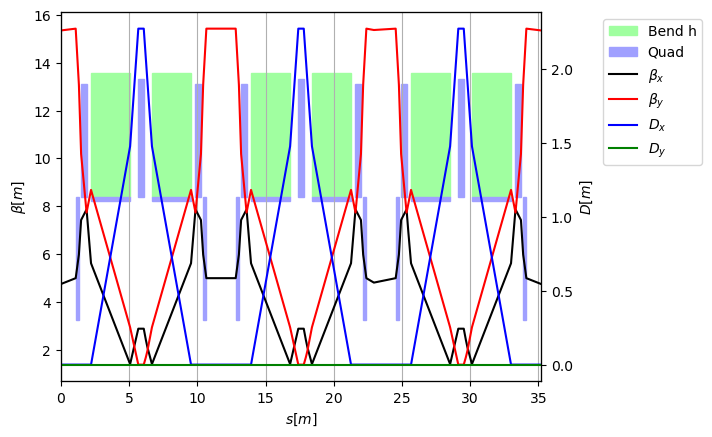

In [3]:
tw.plot()

In [4]:
############################
# Magnet design parameters #
############################

rho = 2.737
phi = 60/180*np.pi
theta_E = 30/180*np.pi
l_magn = rho*phi
gap = 0.07

dipole_k0 = 1/rho
dipole_k1 = -0.11

In [5]:
########################################################
# Resonance driving terms from hamiltonian terms hpqrt #
########################################################

def f(h_func, p, q, r, t, s, mux, muy, tw):
    # Ensure arrays
    s = np.asarray(s)
    mux = np.asarray(mux)
    muy = np.asarray(muy)
    
    # Common factors
    base = h_func(p,q,r,t, tw.s, tw.alfx, tw.alfy, tw.betx, tw.bety) / (1 - np.exp(2 * np.pi * 1j * ((p-q)*tw.qx+(r-t)*tw.qy)))

    # Exponent term depends on each mux value
    exp_term = np.exp(1j * 2*np.pi* ((p-q)*(tw.mux[:, None] - mux[None, :] 
                                            + tw.qx*((tw.mux[:, None] - mux[None, :]) < 0))
                                     + (r-t)*(tw.muy[:, None] - muy[None, :]
                                            + tw.qy*((tw.muy[:, None] - muy[None, :]) < 0))
                                     ))  # shape (len(tw.s), len(mux))

    # Integrand for each mux value → integrate along tw.s
    integrand = base[:, None] * exp_term

    # Integrate along s for each mux
    vals = np.trapezoid(integrand, x=tw.s, axis=0)

    return vals

/home/silke/Documents/repositories/src/bpmeth/fieldmaps.py:589: RuntimeWarning: invalid value encountered in divide
  bp = np.nan_to_num(np.diff(b,prepend=b[0])/dz, copy=True)


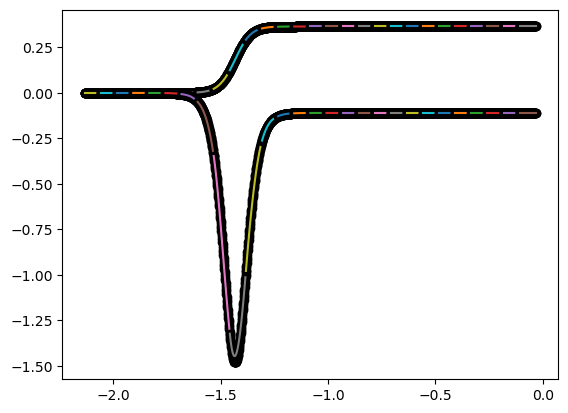

In [6]:
##################################
# Dipole fieldmap and spline fit #
##################################

data = np.loadtxt("../dipole/HeLICS_fieldmap_tanh.csv", skiprows=1, delimiter=',')
magnet = bpmeth.Fieldmap(data)

fig, ax = plt.subplots()
segments, splines = magnet.fit_spline_multipoles(components=[1, 2], step=75, smin=-l_magn/2-10*gap, smax=0, ax=ax)

def segment_indices(xs, segments):
    """Return the segment indices for points xs given uniform [start, end] segments."""
    segment_ends = [segments[0][0]] + [seg[1] for seg in segments]
    x_min = segment_ends[0]
    x_max = segment_ends[-1]
    dx = segment_ends[1] - segment_ends[0]
    num_segments = len(segment_ends) - 1

    xs = np.asarray(xs)
    indices = np.floor((xs - x_min) / dx).astype(int)
    indices = np.clip(indices, 0, num_segments - 1)
    return indices

In [7]:
def heaviside_tol(x, tol=1e-10, h0=0.5):
    """Heaviside step function with numerical tolerance for central value"""
    x = np.asarray(x)
    res = np.zeros_like(x, dtype=float)
    res[x > tol] = 1.0
    res[np.abs(x) <= tol] = h0  # value at the "center"
    return res

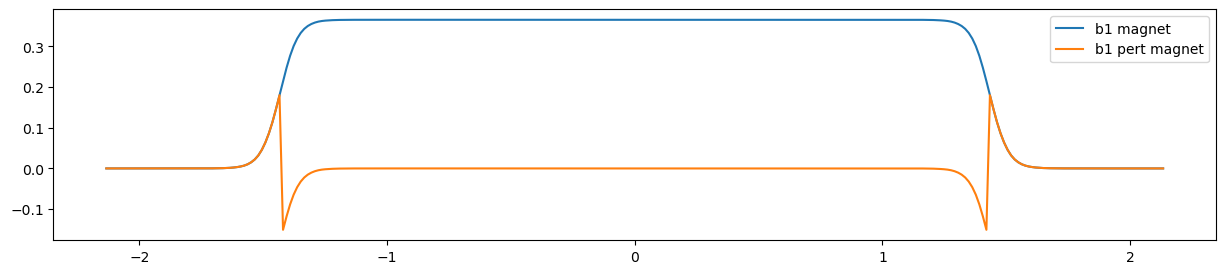

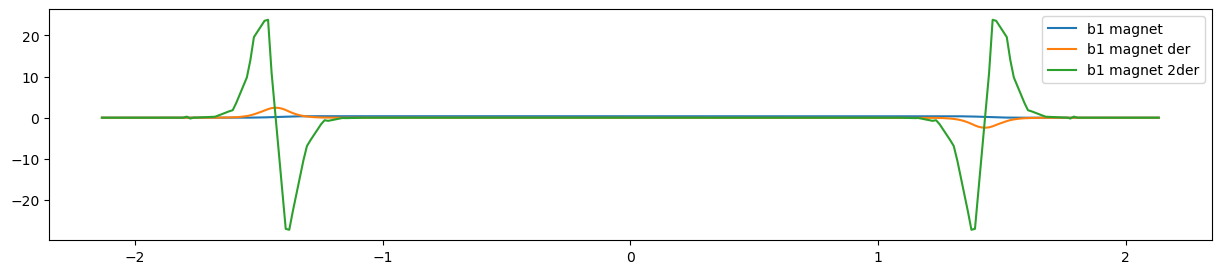

In [22]:
####################################
# Perturbing fields for one dipole #
####################################

def b1_half(s):
    """Return the fitted b1 value at longitudinal position s."""
    idx = segment_indices(s, segments)
    b1_vals = np.array([bpmeth.poly_fit.poly_val(splines[0][i], ss) if ss > -l_magn/2-5*gap else 0 for i, ss in zip(idx, s)])
    return b1_vals

def b1_magnet(s):
    return np.where(s<0, b1_half(s), b1_half(-s))

# def b1_magnet(s):
#     # Slower since it fits the fieldmap every time the function is called, but more accurate
#     return np.array([magnet.fit_xprofile(0, ss, "By", 2, xmax=0.05)[0][0] for ss in s])

# fringelen=gap
# def b1_magnet(s):
#     return (np.tanh( (s+l_magn/2)/fringelen ) + np.tanh( -(s-l_magn/2)/fringelen )) * dipole_k0/2

def hs_magnet(s):
    return (heaviside_tol(s+l_magn/2) - heaviside_tol(s-l_magn/2)) * dipole_k0

def b1_pert_magnet(s):
    return b1_magnet(s) - hs_magnet(s)

def b1_magnet_der(s, h=0.01):
    return (b1_magnet(s + h) - b1_magnet(s - h)) / (2 * h)

def b1_magnet_2der(s, h=0.01):
    return (b1_magnet(s + h) - 2*b1_magnet(s) + b1_magnet(s - h)) / (h**2)

ss = np.linspace(-l_magn/2 - 10*gap, l_magn/2 + 10*gap, 300)
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(ss, b1_magnet(ss), label='b1 magnet')
ax.plot(ss, b1_pert_magnet(ss), label='b1 pert magnet')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(ss, b1_magnet(ss), label='b1 magnet')
ax.plot(ss, b1_magnet_der(ss), label='b1 magnet der')
ax.plot(ss, b1_magnet_2der(ss), label='b1 magnet 2der')
ax.legend()

KeyboardInterrupt: 

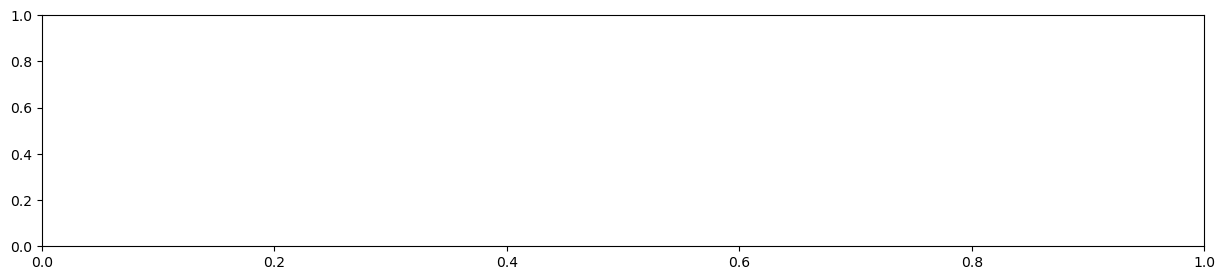

In [15]:

def b2_half(s):
    """Return the fitted b1 value at longitudinal position s."""
    idx = segment_indices(s, segments)
    b1_vals = np.array([bpmeth.poly_fit.poly_val(splines[1][i], ss) if ss > -l_magn/2-5*gap else 0 for i, ss in zip(idx, s)])
    return b1_vals

def b2_magnet(s):
    return np.where(s<0, b2_half(s), b2_half(-s))

# def b2_magnet(s):
#     # Slower since it fits the fieldmap every time the function is called, but more accurate
#     return np.array([magnet.fit_xprofile(0, ss, "By", 2, xmax=0.05)[0][1] for ss in s])

def gaussian(s, s0, sigma):
    return np.exp(-0.5 * ((s - s0)/sigma)**2) / (np.sqrt(2*np.pi) * sigma)

sigma = 0.01
def b2_unpert_magnet(s):
    return (heaviside_tol(s+l_magn/2) - heaviside_tol(s-l_magn/2)) * dipole_k1 \
        - gaussian(s, -l_magn/2, sigma) * dipole_k0 * np.tan(30/180*np.pi) \
            - gaussian(s, l_magn/2, sigma) * dipole_k0 * np.tan(30/180*np.pi)

def b2_pert_magnet(s):
    return b2_magnet(s) - b2_unpert_magnet(s)

def b2_magnet_der(s, h=0.01):
    return (b2_magnet(s + h) - b2_magnet(s - h)) / (2 * h)

def b2_magnet_2der(s, h=0.01):
    return (b2_magnet(s + h) - 2*b2_magnet(s) + b2_magnet(s - h)) / (h**2)

ss = np.linspace(-l_magn/2 - 10*gap, l_magn/2 + 10*gap, 1000)
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(ss, b2_magnet(ss), label='b2 magnet')
ax.plot(ss, b2_pert_magnet(ss), label='b2 pert magnet')
print("Integrated perturbing b2:", np.trapz(b2_pert_magnet(ss), ss))
ax.set_ylim(-2, 2)
ax.legend()

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(ss, b2_magnet(ss), label='b2 magnet')
ax.plot(ss, b2_magnet_der(ss), label='b2 magnet der')
ax.plot(ss, b2_magnet_2der(ss), label='b2 magnet 2der')
ax.legend()

KeyboardInterrupt: 

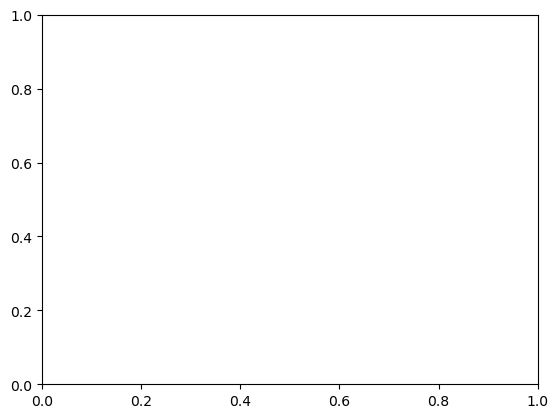

In [16]:
####################################
# Perturbing fields for whole ring #
####################################

tab = line.get_table()
dipole_centers = tab['s_center'][tab["element_type"] == 'Bend']

def b1_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_magnet(s - dc)
    return total

def hs_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += hs_magnet(s - dc)
    return total

def b1_pert_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_pert_magnet(s - dc)
    return total

def b1_ring_der(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_magnet_der(s - dc)
    return total

def b1_ring_2der(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b1_magnet_2der(s - dc)
    return total

ss = np.linspace(0, line.get_length(), 5000)
fig, ax = plt.subplots()
ax.plot(ss, b1_ring(ss), label='Full dipole model')
ax.plot(ss, b1_pert_ring(ss), label='Perturbation model')

KeyboardInterrupt: 

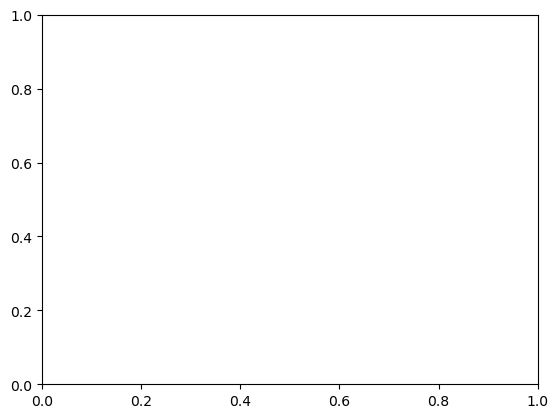

In [17]:
def b2_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b2_magnet(s - dc)
    return total

def b2_pert_ring(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b2_pert_magnet(s - dc)
    return total

def b2_ring_der(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b2_magnet_der(s - dc)
    return total

def b2_ring_2der(s):
    s = np.asarray(s)  # ensure array input
    total = np.zeros_like(s, dtype=float)
    for dc in dipole_centers:
        total += b2_magnet_2der(s - dc)
    return total

ss = np.linspace(0, line.get_length(), 5000)
fig, ax = plt.subplots()
ax.plot(ss, b2_ring(ss), label='Full quadrupole model')
ax.plot(ss, b2_pert_ring(ss), label='Perturbation model')


In [18]:
###################
# Field expansion #
###################

s = sp.symbols("s")
hs = sp.symbols("hs")
b1 = sp.Function("b1")(s)
b2 = sp.Function("b2")(s)

dip_straight = bpmeth.FieldExpansion(b=(b1, ))
dip_curved = bpmeth.FieldExpansion(b=(b1, ), hs=hs)
quad_curved = bpmeth.FieldExpansion(b=("0", b2), hs=hs)

#################
# Symbolic RDTs #
#################

order = 3
betx, bety, alphx, alphy = sp.symbols("beta_x beta_y alpha_x alpha_y")
h_dip_straight = dip_straight.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)
h_dip_curved = dip_curved.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)

h_quad_curved = quad_curved.calc_RDTs(order, betx=betx, bety=bety, alphx=alphx, alphy=alphy)


In [19]:
#####################################################
# Transform the symbolic expressions into functions #
#####################################################

b10, b11, b12 = sp.symbols("b10 b11 b12")
subs_set_dip = {dip_curved.b[0]:b10, 
            sp.Derivative(dip_curved.b[0], dip_curved.s): b11, 
            sp.Derivative(dip_curved.b[0], dip_curved.s, dip_curved.s): b12}

h_fringe_array_dip = np.empty_like(h_dip_curved, dtype=object)
for index, expr in np.ndenumerate(h_dip_curved):
    if expr !=0:
        h_fringe_array_dip[index] = sp.lambdify((alphx, alphy, betx, bety, b10, b11, b12, hs), 
                                          expr.subs(subs_set_dip), modules='numpy')
    else:
        h_fringe_array_dip[index] = sp.lambdify(
            (alphx, alphy, betx, bety, b10, b11, b12, hs),
            0,
            modules='numpy')
        
b20, b21, b22 = sp.symbols("b20 b21 b22")
subs_set_quad = {quad_curved.b[1]:b20, 
            sp.Derivative(quad_curved.b[1], quad_curved.s): b21, 
            sp.Derivative(quad_curved.b[1], quad_curved.s, quad_curved.s): b22}

h_fringe_array_quad = np.empty_like(h_quad_curved, dtype=object)
for index, expr in np.ndenumerate(h_quad_curved):
    if expr !=0:
        h_fringe_array_quad[index] = sp.lambdify((alphx, alphy, betx, bety, b20, b21, b22, hs), 
                                          expr.subs(subs_set_quad), modules='numpy')
    else:
        h_fringe_array_quad[index] = sp.lambdify(
            (alphx, alphy, betx, bety, b20, b21, b22, hs),
            0,
            modules='numpy')
        
def h_fringe(p, q, r, t, s, alphx, alphy, betx, bety):
    """
    Vectorized numerical evaluation of h[p,q,r,t].
    All arguments (alphx, alphy, betx, bety, s) can be NumPy arrays of the same shape.
    """

    b10_val, b11_val, b12_val = b1_pert_ring(s), b1_ring_der(s), b1_ring_2der(s)
    b20_val, b21_val, b22_val = b2_pert_ring(s), b2_ring_der(s), b2_ring_2der(s)
    hval = hs_ring(s)
    return h_fringe_array_dip[p, q, r, t](alphx, alphy, betx, bety, b10_val, b11_val, b12_val, hval) \
        + h_fringe_array_quad[p, q, r, t](alphx, alphy, betx, bety, b20_val, b21_val, b22_val, hval)

In [20]:
#################################################
# The closed orbit distortion from f1000, f0100 #
#################################################

def deltax(s, mux, muy, betx, tw):
    return -np.sqrt(betx) * 1j * (f(h_fringe, 0,1,0,0,s, mux, muy, tw) - f(h_fringe, 1,0,0,0,s, mux, muy, tw))

######################################
# The beta beating from f2000, f0200 #
######################################

def delbetx(s, mux, muy, betx, tw):
    return 4 * betx * 1j * (f(h_fringe, 2,0,0,0,s, mux, muy, tw) - f(h_fringe, 0,2,0,0,s, mux, muy, tw))

def delbety(s, mux, muy, bety, tw):
    return 4 * bety * 1j * (f(h_fringe, 0,0,2,0,s, mux, muy, tw) - f(h_fringe, 0,0,0,2,s, mux, muy, tw))

Slicing line: 100%|██████████| 1357/1357 [00:00<00:00, 609647.66it/s]


KeyboardInterrupt: 

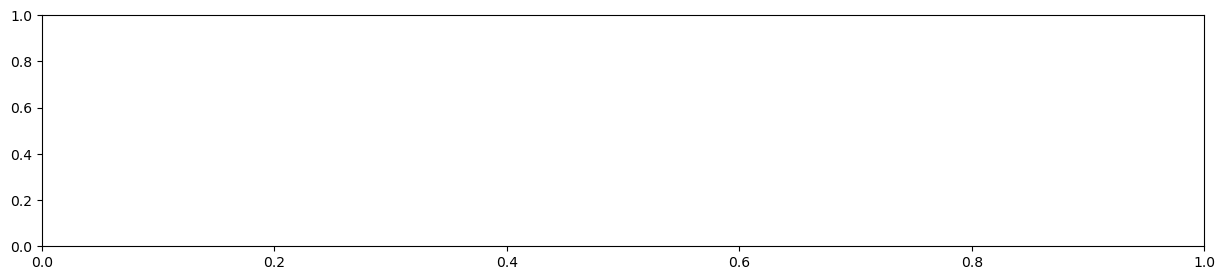

In [21]:
###################################################
# Slice lattice symmetrically around dipole edges #
###################################################

line_sliced = line.copy()

# Evenly spaced around dipole edges. Cancellations play a role, 
# so symmetry is important - we don't want to include a net dipole field!
ns = 101
s_to_slice = np.array([[np.linspace(dc - l_magn/2 - 5*gap, dc - l_magn/2 + 5*gap, ns) for dc in dipole_centers], 
                       [np.linspace(dc + l_magn/2 - 5*gap, dc + l_magn/2 + 5*gap, ns) for dc in dipole_centers], 
                       ]).flatten()
s_to_slice = np.append(s_to_slice, ([dc - l_magn*i for dc in dipole_centers[::2] for i in np.linspace(0.75, 1.15, 3)], 
                                    [dc + l_magn*i for dc in dipole_centers[1::2] for i in np.linspace(0.75, 1.15, 3)]))
s_to_slice = np.sort(np.append(s_to_slice, dipole_centers))

line_sliced.cut_at_s(s_to_slice)
tw = line_sliced.twiss4d(at_s = s_to_slice)

# Inspect points around first dipole
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(tw.s, b1_pert_ring(tw.s), marker='.', linewidth=0.5)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(tw.s, b2_pert_ring(tw.s), marker='.', linewidth=0.5)
ax.set_xlim(1, 6)


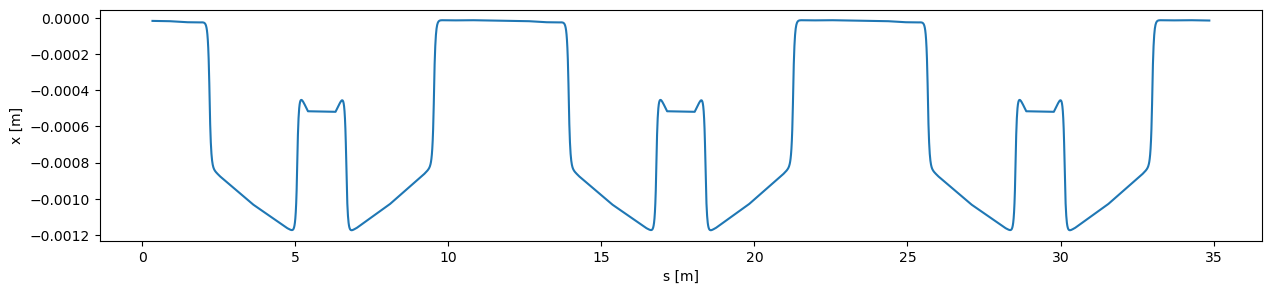

In [17]:
################################
# Plot closed orbit distortion #
################################

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(tw.s, deltax(tw.s, tw.mux, tw.muy, tw.betx, tw).real, label='closed orbit distortion')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
plt.savefig("figures/ELENA_closed_orbit_distortion_due_to_dipole_fringes.png", dpi=300)


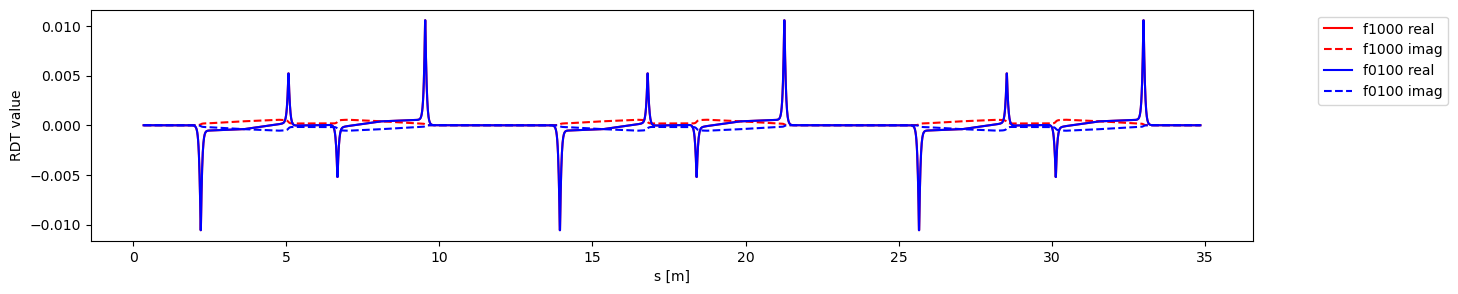

In [18]:
#####################################################
# Plot RDTs responsible for closed orbit distortion #
#####################################################

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(tw.s, f(h_fringe, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f1000 real", color="red")
ax.plot(tw.s, f(h_fringe, 1,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f1000 imag", color="red", ls='--')
ax.plot(tw.s, f(h_fringe, 0,1,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f0100 real", color="blue")
ax.plot(tw.s, f(h_fringe, 0,1,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f0100 imag", color="blue", ls='--')
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

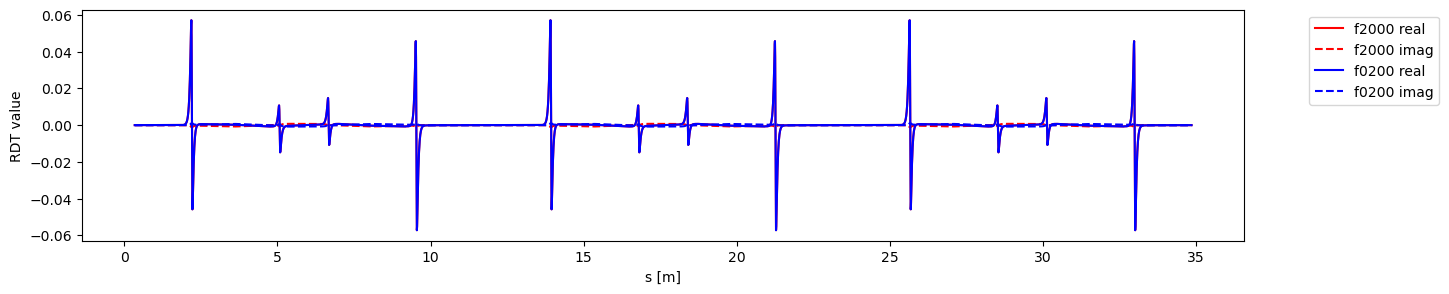

In [19]:
#############################
# Plot main quadrupole RDTs #
#############################

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(tw.s, f(h_fringe, 2,0,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f2000 real", color="red")
ax.plot(tw.s, f(h_fringe, 2,0,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f2000 imag", color="red", ls='--')
ax.plot(tw.s, f(h_fringe, 0,2,0,0, tw.s, tw.mux, tw.muy, tw).real, label="f0200 real", color="blue")
ax.plot(tw.s, f(h_fringe, 0,2,0,0, tw.s, tw.mux, tw.muy, tw).imag, label="f0200 imag", color="blue", ls='--')
ax.set_xlabel('s [m]')
ax.set_ylabel('RDT value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

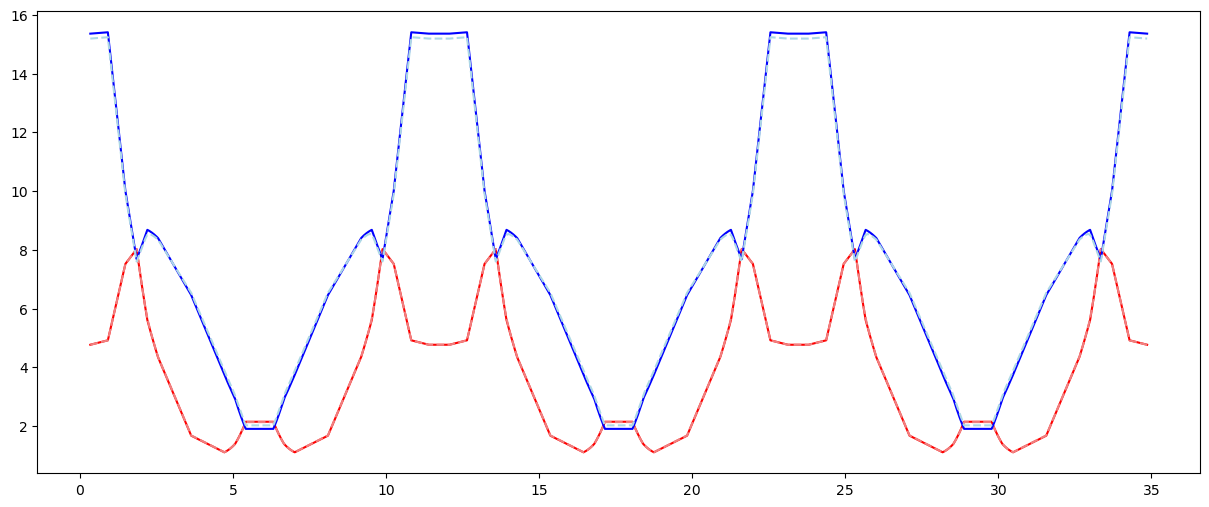

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(tw.s, tw.betx, label="Unperturbed betx", color="red")
ax.plot(tw.s, tw.betx + delbetx(tw.s, tw.mux, tw.muy, tw.betx, tw).real, label="Perturbed betx", color="lightcoral", ls='--')
ax.plot(tw.s, tw.bety, label="Unperturbed bety", color="blue")
ax.plot(tw.s, tw.bety + delbety(tw.s, tw.mux, tw.muy, tw.bety, tw).real, label="Perturbed bety", color="lightblue", ls='--')

# This does not include the effect of the fringe field integral! This originates from the second order RDTs